# Example: TabNet does not learn interesting features

Dataset: Census-Income 
Experiments:
* 1: We provide interesting features for the model. 
* 2: We provide a lot of features for the model to choose.

In [1]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def predict(model, x, y, dataset_name):
    y_pred = model.predict(x).reshape(-1)
    y_true = y.reshape(-1)
    score = mean_squared_error(y_pred=y_pred, y_true=y_true)
#     print(f"BEST VALID SCORE FOR {dataset_name} : {model.best_cost}")
    print(f"SCORE FOR {dataset_name} : {score}")
    return y_true, y_pred


def plot_results(y_true, y_pred):
    plt.figure(figsize=(15, 8))
    df_result = pd.DataFrame({'y_true': y_true,
                             'y_pred': y_pred}).reset_index().rename(columns={'index': 'date'})
    df_result_melted = pd.melt(df_result, id_vars=['date'], value_vars=['y_true', 'y_pred'])
    ax = sns.lineplot(x='date', y='value', hue='variable', data=df_result_melted)

In [3]:
def _generate_autoregressive_feature(X_y, step=1):
    X_y[f'passengers_-{step}'] = X_y['passengers'].shift(step) 
    # fillna strategy
    X_y.loc[X_y[f'passengers_-{step}'].isna(), f'passengers_-{step}'] = X_y.loc[X_y[f'passengers_-{step}'].isna(), 'passengers']
    return X_y

---
# Common Phases
### Download Flight-Passanger dataset

In [4]:
url = 'https://raw.githubusercontent.com/BhavyaGulati/TimeSeries-FlightPassesngerPrediction/master/international-airline-passengers.csv'

In [5]:
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'international-airline-passengers'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [6]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


---
### Load data

In [7]:
data = pd.read_csv(out, header=None).rename(columns={0: 'date', 1: 'passengers'})
# clean
data = data.loc[~(data['date']== 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60')]
data['date'] = pd.to_datetime(data['date'], format='%Y-%m')
data.sort_values('date', inplace=True)
data.head()

,date,passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


In [8]:
display(data.shape)
display(data.shape[0] / 12)

(144, 2)

12.0

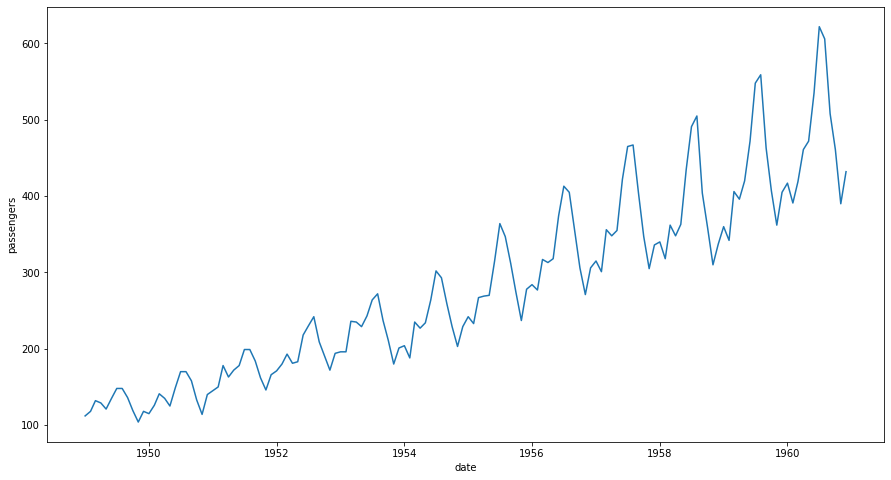

In [9]:
plt.figure(figsize=(15, 8))
ax = sns.lineplot(x='date', y='passengers', data=data)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

We can see that the timeseries have clearly two components: 
* Seasonality
* Trend

### Train-Validation-Test Split

In [10]:
validation_fraction, test_fraction = (0.2, 0.2)
train_fraction = 1 - validation_fraction - test_fraction

Because we are dealing with timeseries data, we will train on the first segment of data, validate with the second one, and test with the most recent chunk.

In [11]:
n_train = int(round(len(data) * train_fraction))
print(f'Using {n_train} points to train')

n_val = int(round(len(data) * validation_fraction))
print(f'Using {n_val} points to validate')

n_test = len(data) - n_train - n_val
print(f'Using {n_test} points to test')

Using 86 points to train
Using 29 points to validate
Using 29 points to test


---
---
---

---
---
---

### Feature Generation

We pass on the features in the previous months

In [13]:
steps = list(range(1, 13))
steps = [1, 12]

X_y = data.copy()
FEATURES_TO_USE = []
for step in steps:
    X_y = _generate_autoregressive_feature(X_y, step=step)
    FEATURES_TO_USE.append(f'passengers_-{step}')
X_y.tail(13)

,date,passengers,passengers_-1,passengers_-12
131,1959-12-01,405.0,362.0,337.0
132,1960-01-01,417.0,405.0,360.0
133,1960-02-01,391.0,417.0,342.0
134,1960-03-01,419.0,391.0,406.0
135,1960-04-01,461.0,419.0,396.0
136,1960-05-01,472.0,461.0,420.0
137,1960-06-01,535.0,472.0,472.0
138,1960-07-01,622.0,535.0,548.0
139,1960-08-01,606.0,622.0,559.0
140,1960-09-01,508.0,606.0,463.0


In [14]:
X = X_y[FEATURES_TO_USE].values
y = X_y[['passengers']].values

In [15]:
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test, y_test = X[n_train+n_val:], y[n_train + n_val:]

# HyperParameter Tuning

In [16]:
import mlflow

def get_model_parameters(n_steps_values, gamma_values, lambda_sparse_values, model_capacity_values):
    for n_steps in n_steps_values:
        for gamma in gamma_values:
            for lambda_sparse in lambda_sparse_values:
                for model_capacity in model_capacity_values :
                    n_d = model_capacity
                    n_a = model_capacity
                    model_parameters = {'n_steps': n_steps,
                                        'gamma': gamma,
                                        'lambda_sparse': lambda_sparse,
                                        'n_d': n_d,
                                        'n_a': n_a,
                                       'verbose': VERBOSE}
                    yield model_parameters
                    
def plot_learning_curves(losses_train, losses_valid, plot=True, save=False):
    plt.figure(figsize=(12, 6));
    plt.plot(losses_train, 'b');
    plt.plot(losses_valid, 'r');
    
    if save:
        plt.savefig('artifacts/learning_curve.png');
        
    if plot:
        plt.show();
                    
import os

def delete_artifacts(): 
    files = os.listdir('./artifacts')
    for f in files:
        os.remove('./artifacts/' + f)

## Create Model

In [17]:
n_steps_values = [1, 3]
gamma_values = [1, 1.3]
lambda_sparse_values = [1e-3, 1e-1, 1, 10, 100]
model_capacity_values = [3, 4, 8, 16]

# n_steps_values = [1, 3]
# gamma_values = [1]
# lambda_sparse_values = [1e-3]
# model_capacity_values = [3]


/home/user/miniconda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
VERBOSE = 0

In [19]:
URI = 'http://0.0.0.0:5000'
mlflow.set_tracking_uri(URI)
mlflow.tracking.get_tracking_uri()

'http://0.0.0.0:5000'

In [20]:
EXPERIMENT_NAME = 'Seb Advice'
EXPERIMENT_NAME = 'Seb Advice - 2 Features'

mlflow.set_experiment(EXPERIMENT_NAME)

INFO: 'Seb Advice - 2 Features' does not exist. Creating a new experiment


In [21]:
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
print(experiment)
experiment_id = experiment.experiment_id
print(experiment_id)

<Experiment: artifact_location='./mlruns/3', experiment_id='3', lifecycle_stage='active', name='Seb Advice - 2 Features', tags={}>
3


In [22]:
max_epochs = 1000

{'n_steps': 1, 'gamma': 1, 'lambda_sparse': 0.001, 'n_d': 3, 'n_a': 3, 'verbose': 0}
Device used : cuda
{'n_steps': 1, 'gamma': 1, 'lambda_sparse': 0.001, 'n_d': 4, 'n_a': 4, 'verbose': 0}
Device used : cuda
{'n_steps': 1, 'gamma': 1, 'lambda_sparse': 0.001, 'n_d': 8, 'n_a': 8, 'verbose': 0}
Device used : cuda
{'n_steps': 1, 'gamma': 1, 'lambda_sparse': 0.001, 'n_d': 16, 'n_a': 16, 'verbose': 0}
Device used : cuda
{'n_steps': 1, 'gamma': 1, 'lambda_sparse': 0.1, 'n_d': 3, 'n_a': 3, 'verbose': 0}
Device used : cuda
{'n_steps': 1, 'gamma': 1, 'lambda_sparse': 0.1, 'n_d': 4, 'n_a': 4, 'verbose': 0}
Device used : cuda
{'n_steps': 1, 'gamma': 1, 'lambda_sparse': 0.1, 'n_d': 8, 'n_a': 8, 'verbose': 0}
Device used : cuda
{'n_steps': 1, 'gamma': 1, 'lambda_sparse': 0.1, 'n_d': 16, 'n_a': 16, 'verbose': 0}
Device used : cuda
{'n_steps': 1, 'gamma': 1, 'lambda_sparse': 1, 'n_d': 3, 'n_a': 3, 'verbose': 0}
Device used : cuda
{'n_steps': 1, 'gamma': 1, 'lambda_sparse': 1, 'n_d': 4, 'n_a': 4, 'verb

<ipython-input-16-c919ff0b3034>:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6));


{'n_steps': 1, 'gamma': 1.3, 'lambda_sparse': 0.001, 'n_d': 4, 'n_a': 4, 'verbose': 0}
Device used : cuda
{'n_steps': 1, 'gamma': 1.3, 'lambda_sparse': 0.001, 'n_d': 8, 'n_a': 8, 'verbose': 0}
Device used : cuda
{'n_steps': 1, 'gamma': 1.3, 'lambda_sparse': 0.001, 'n_d': 16, 'n_a': 16, 'verbose': 0}
Device used : cuda
{'n_steps': 1, 'gamma': 1.3, 'lambda_sparse': 0.1, 'n_d': 3, 'n_a': 3, 'verbose': 0}
Device used : cuda
{'n_steps': 1, 'gamma': 1.3, 'lambda_sparse': 0.1, 'n_d': 4, 'n_a': 4, 'verbose': 0}
Device used : cuda
{'n_steps': 1, 'gamma': 1.3, 'lambda_sparse': 0.1, 'n_d': 8, 'n_a': 8, 'verbose': 0}
Device used : cuda
{'n_steps': 1, 'gamma': 1.3, 'lambda_sparse': 0.1, 'n_d': 16, 'n_a': 16, 'verbose': 0}
Device used : cuda
{'n_steps': 1, 'gamma': 1.3, 'lambda_sparse': 1, 'n_d': 3, 'n_a': 3, 'verbose': 0}
Device used : cuda
{'n_steps': 1, 'gamma': 1.3, 'lambda_sparse': 1, 'n_d': 4, 'n_a': 4, 'verbose': 0}
Device used : cuda
{'n_steps': 1, 'gamma': 1.3, 'lambda_sparse': 1, 'n_d': 8,

/home/user/miniconda/lib/python3.8/site-packages/pytorch_tabnet/tab_model.py:487: RuntimeWarning: invalid value encountered in true_divide
  self.feature_importances_ = feature_importances_ / np.sum(feature_importances_)


{'n_steps': 3, 'gamma': 1, 'lambda_sparse': 0.001, 'n_d': 4, 'n_a': 4, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1, 'lambda_sparse': 0.001, 'n_d': 8, 'n_a': 8, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1, 'lambda_sparse': 0.001, 'n_d': 16, 'n_a': 16, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1, 'lambda_sparse': 0.1, 'n_d': 3, 'n_a': 3, 'verbose': 0}
Device used : cuda


/home/user/miniconda/lib/python3.8/site-packages/pytorch_tabnet/tab_model.py:487: RuntimeWarning: invalid value encountered in true_divide
  self.feature_importances_ = feature_importances_ / np.sum(feature_importances_)


{'n_steps': 3, 'gamma': 1, 'lambda_sparse': 0.1, 'n_d': 4, 'n_a': 4, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1, 'lambda_sparse': 0.1, 'n_d': 8, 'n_a': 8, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1, 'lambda_sparse': 0.1, 'n_d': 16, 'n_a': 16, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1, 'lambda_sparse': 1, 'n_d': 3, 'n_a': 3, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1, 'lambda_sparse': 1, 'n_d': 4, 'n_a': 4, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1, 'lambda_sparse': 1, 'n_d': 8, 'n_a': 8, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1, 'lambda_sparse': 1, 'n_d': 16, 'n_a': 16, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1, 'lambda_sparse': 10, 'n_d': 3, 'n_a': 3, 'verbose': 0}
Device used : cuda


/home/user/miniconda/lib/python3.8/site-packages/pytorch_tabnet/tab_model.py:487: RuntimeWarning: invalid value encountered in true_divide
  self.feature_importances_ = feature_importances_ / np.sum(feature_importances_)


{'n_steps': 3, 'gamma': 1, 'lambda_sparse': 10, 'n_d': 4, 'n_a': 4, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1, 'lambda_sparse': 10, 'n_d': 8, 'n_a': 8, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1, 'lambda_sparse': 10, 'n_d': 16, 'n_a': 16, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1, 'lambda_sparse': 100, 'n_d': 3, 'n_a': 3, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1, 'lambda_sparse': 100, 'n_d': 4, 'n_a': 4, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1, 'lambda_sparse': 100, 'n_d': 8, 'n_a': 8, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1, 'lambda_sparse': 100, 'n_d': 16, 'n_a': 16, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1.3, 'lambda_sparse': 0.001, 'n_d': 3, 'n_a': 3, 'verbose': 0}
Device used : cuda


/home/user/miniconda/lib/python3.8/site-packages/pytorch_tabnet/tab_model.py:487: RuntimeWarning: invalid value encountered in true_divide
  self.feature_importances_ = feature_importances_ / np.sum(feature_importances_)


{'n_steps': 3, 'gamma': 1.3, 'lambda_sparse': 0.001, 'n_d': 4, 'n_a': 4, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1.3, 'lambda_sparse': 0.001, 'n_d': 8, 'n_a': 8, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1.3, 'lambda_sparse': 0.001, 'n_d': 16, 'n_a': 16, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1.3, 'lambda_sparse': 0.1, 'n_d': 3, 'n_a': 3, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1.3, 'lambda_sparse': 0.1, 'n_d': 4, 'n_a': 4, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1.3, 'lambda_sparse': 0.1, 'n_d': 8, 'n_a': 8, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1.3, 'lambda_sparse': 0.1, 'n_d': 16, 'n_a': 16, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1.3, 'lambda_sparse': 1, 'n_d': 3, 'n_a': 3, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1.3, 'lambda_sparse': 1, 'n_d': 4, 'n_a': 4, 'verbose': 0}
Device used : cuda
{'n_steps': 3, 'gamma': 1.3, 'lambda_sparse': 1, 'n_d': 8,

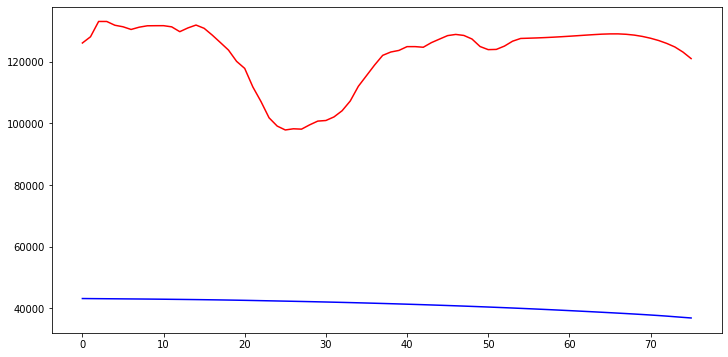

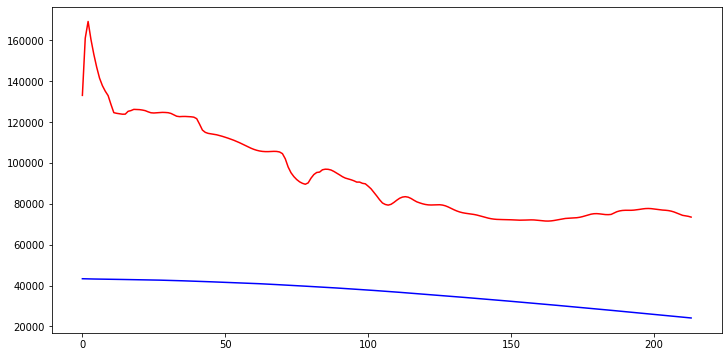

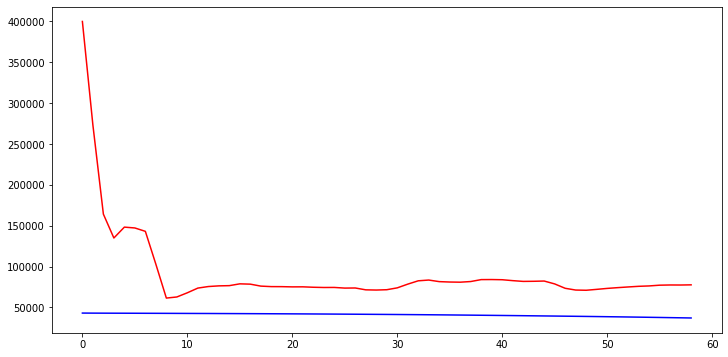

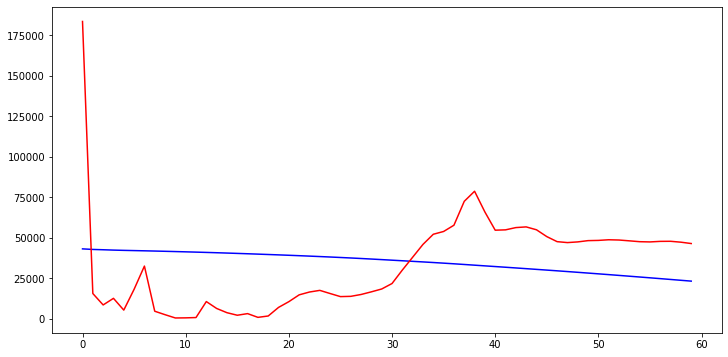

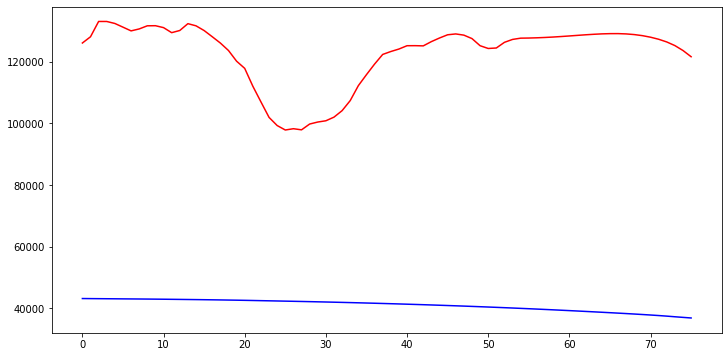

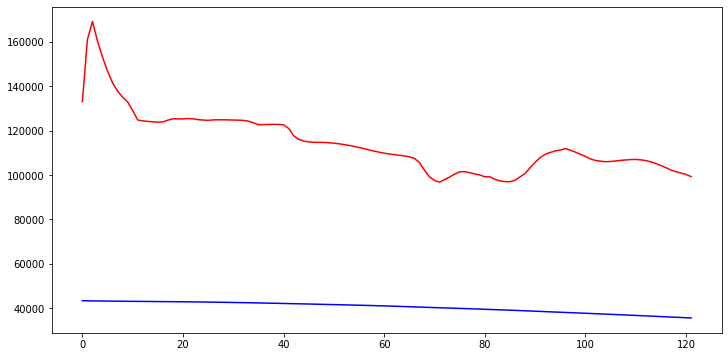

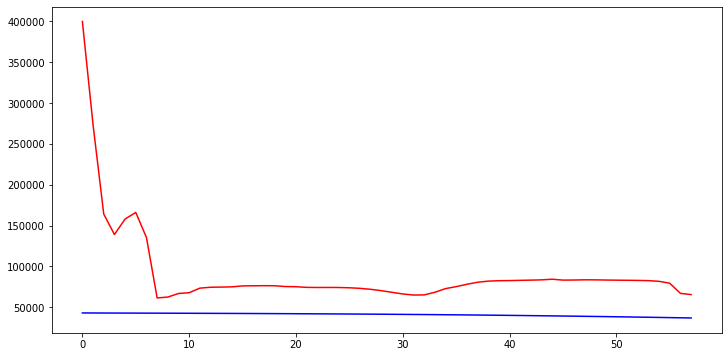

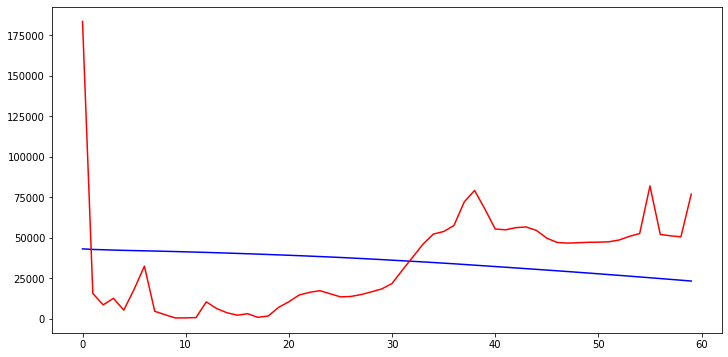

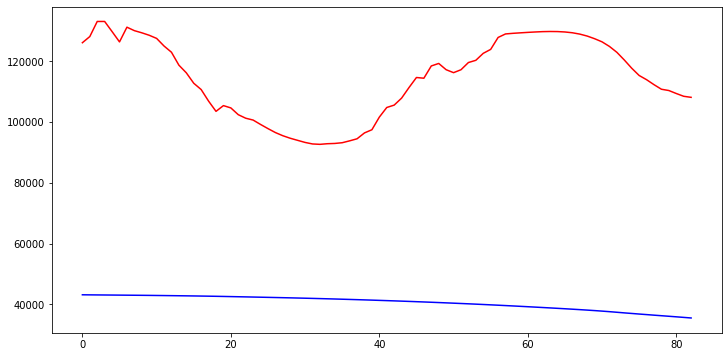

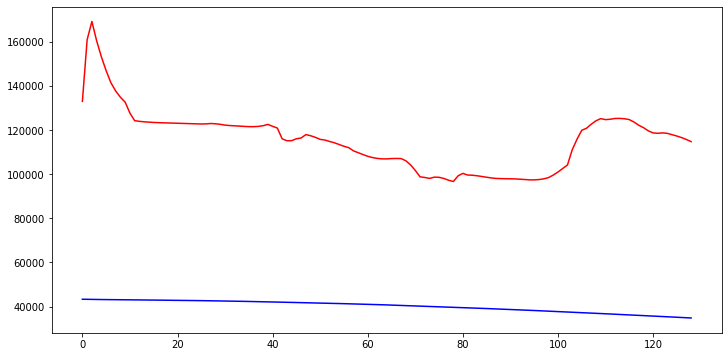

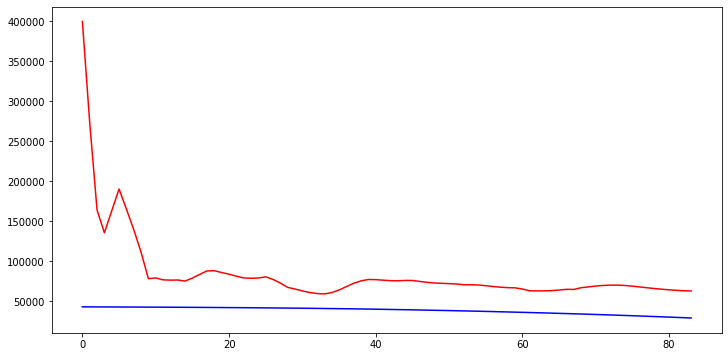

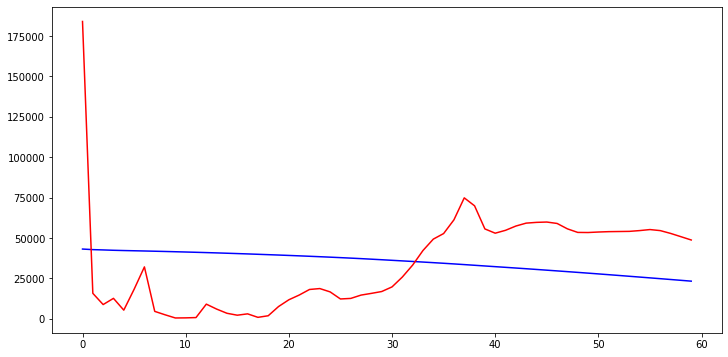

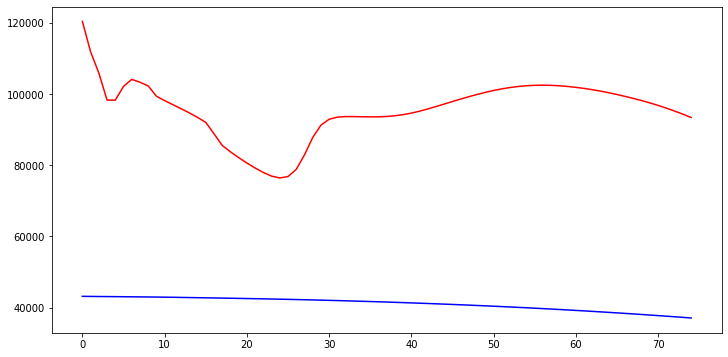

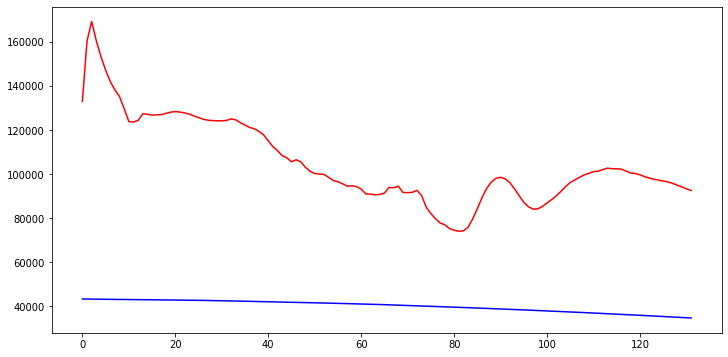

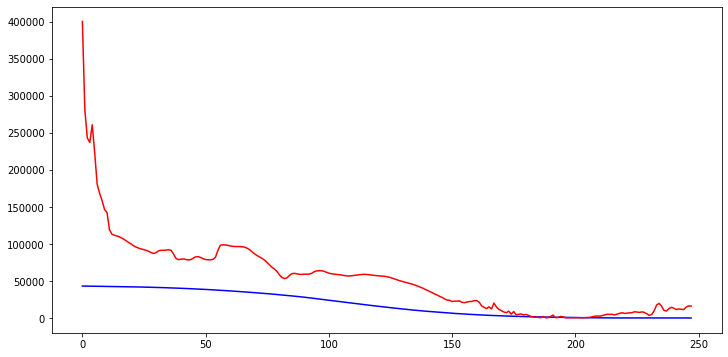

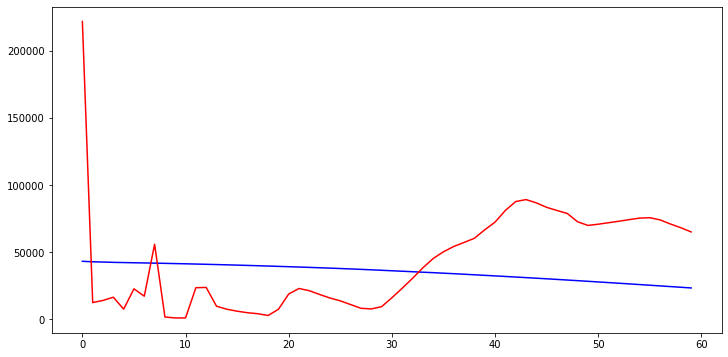

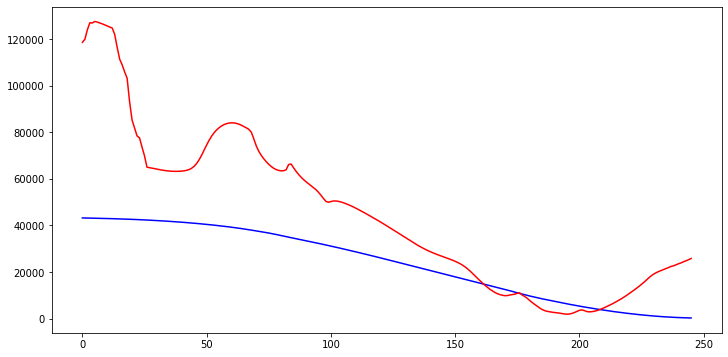

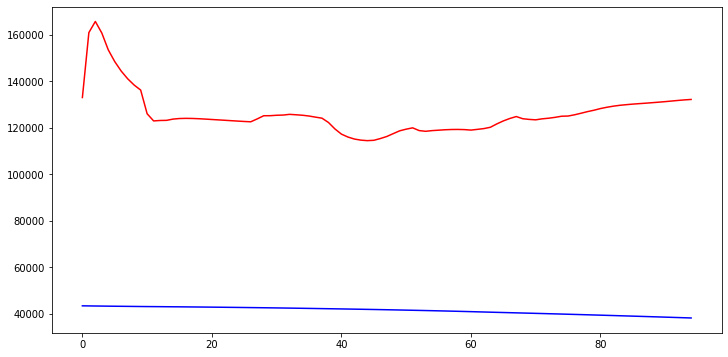

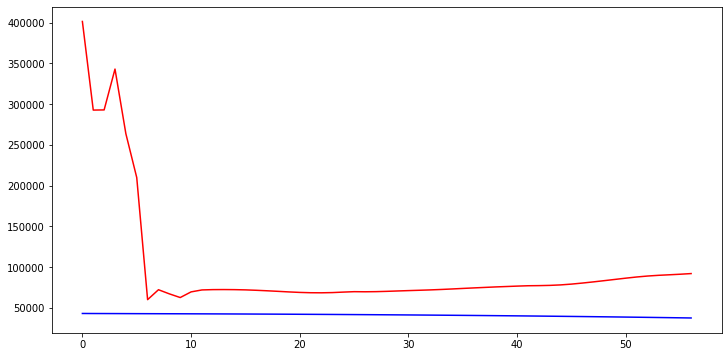

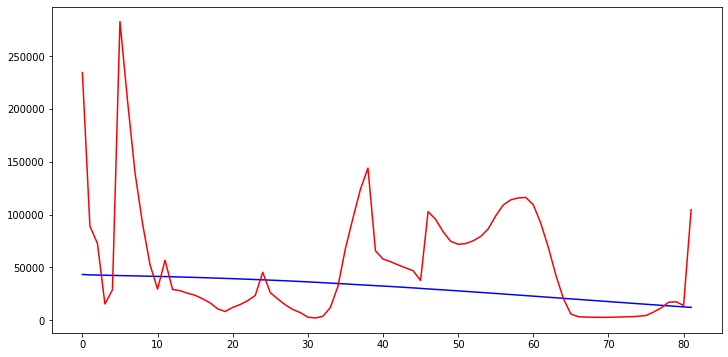

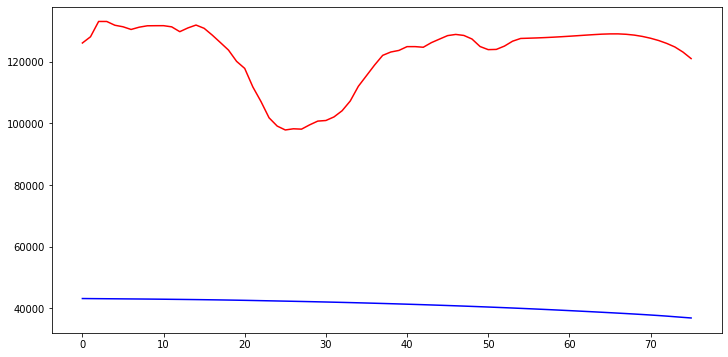

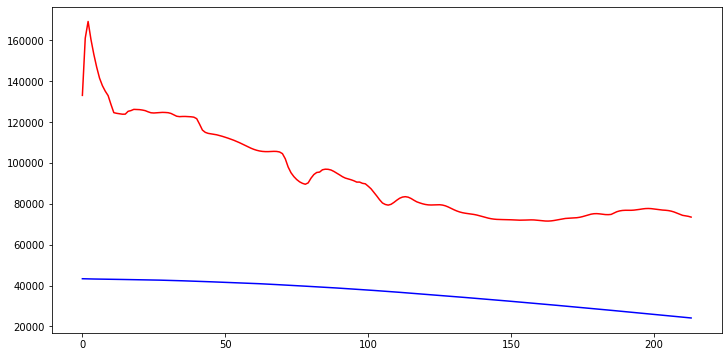

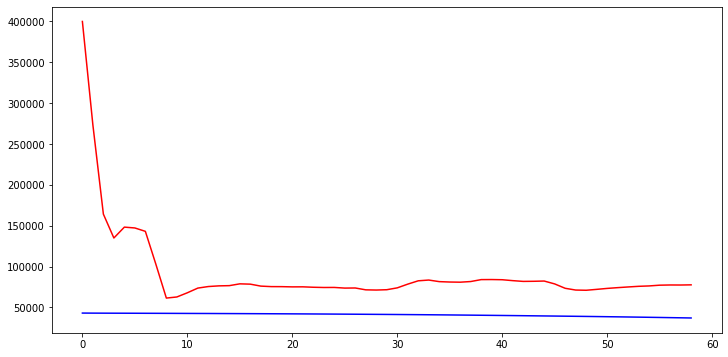

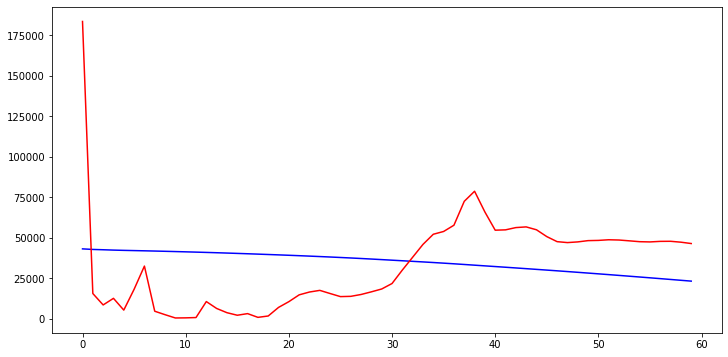

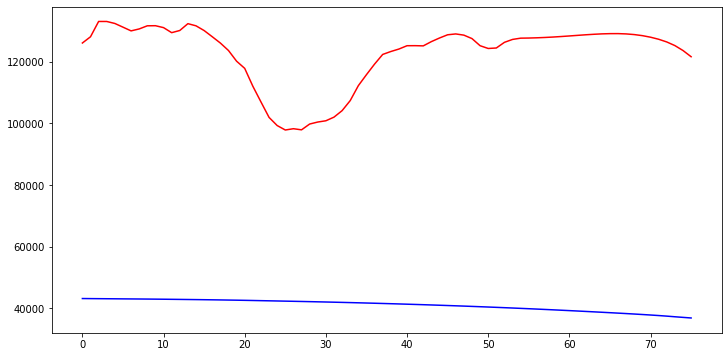

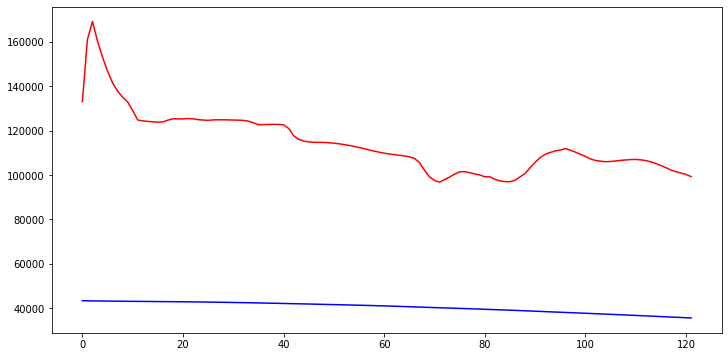

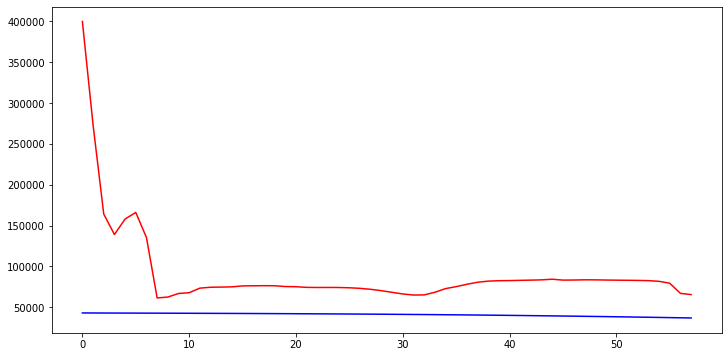

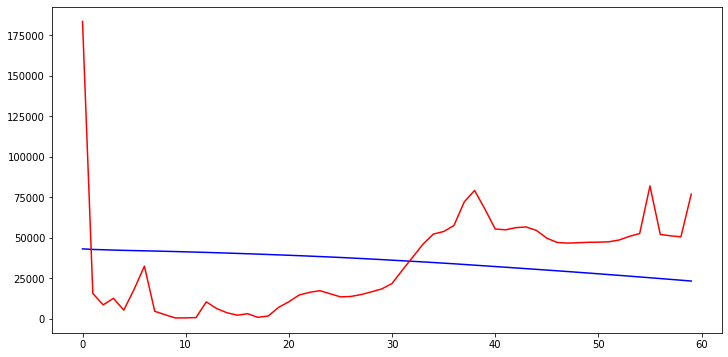

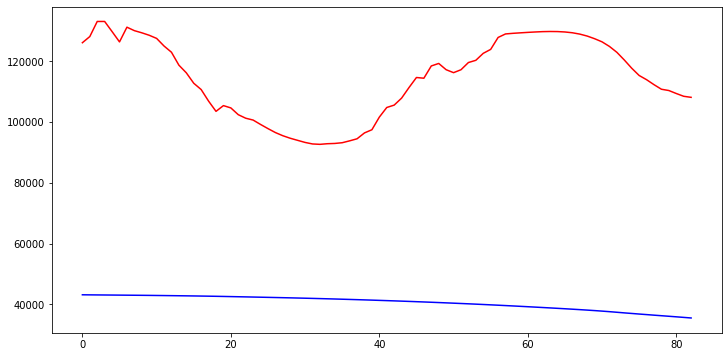

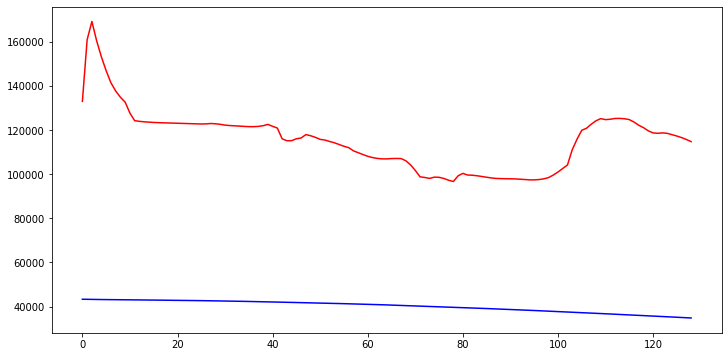

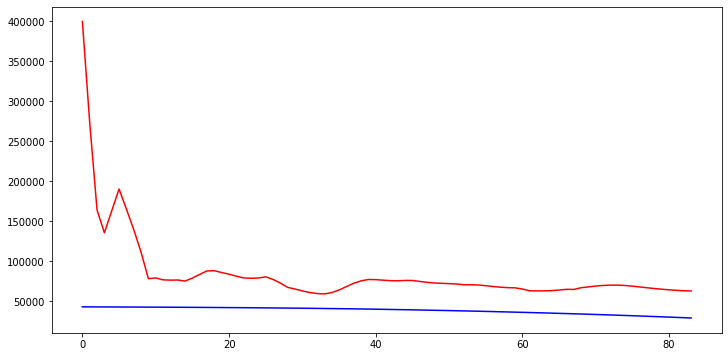

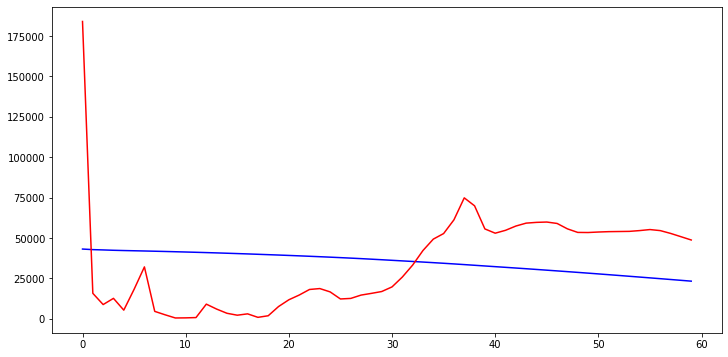

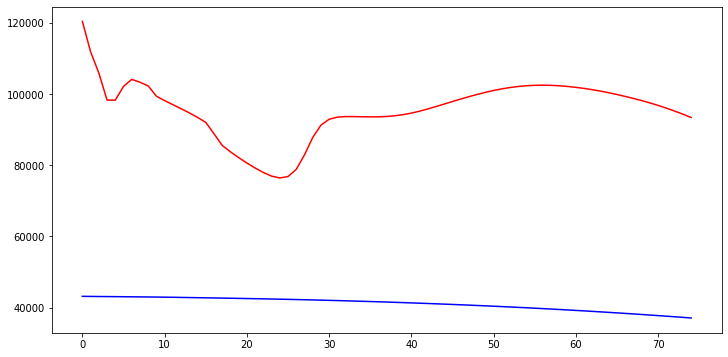

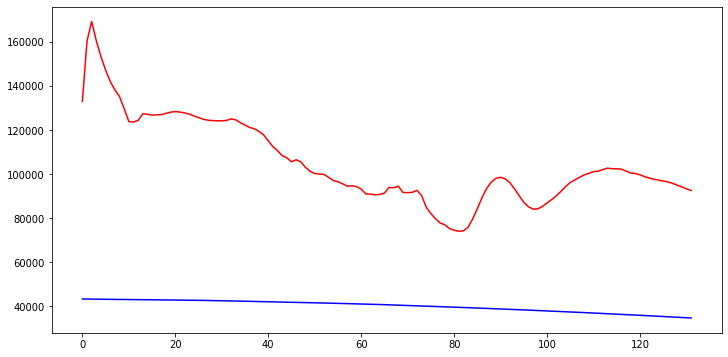

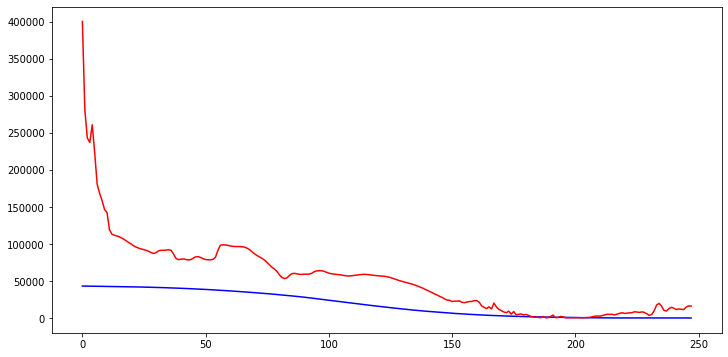

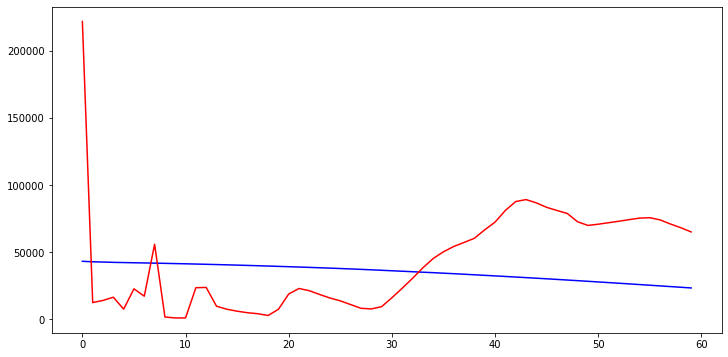

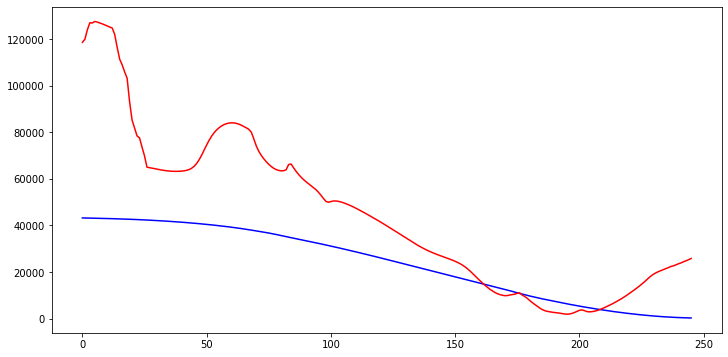

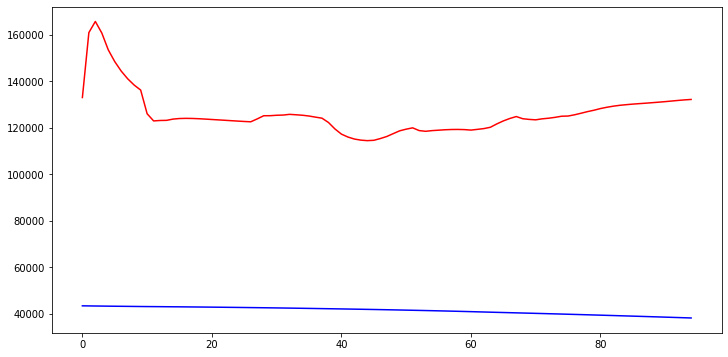

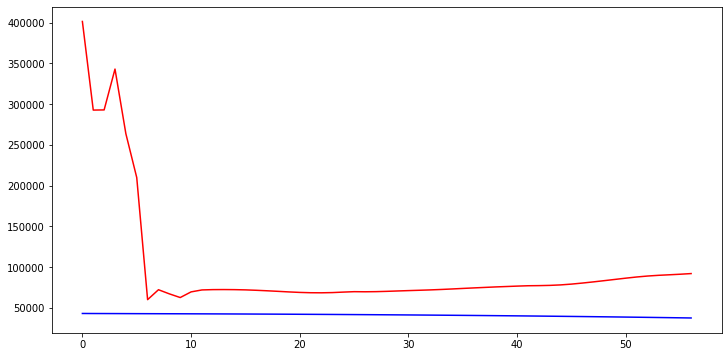

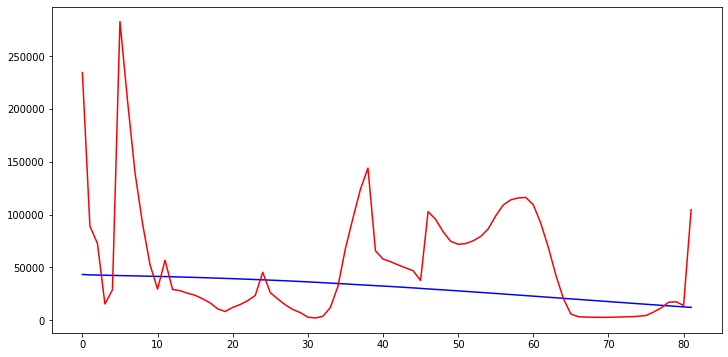

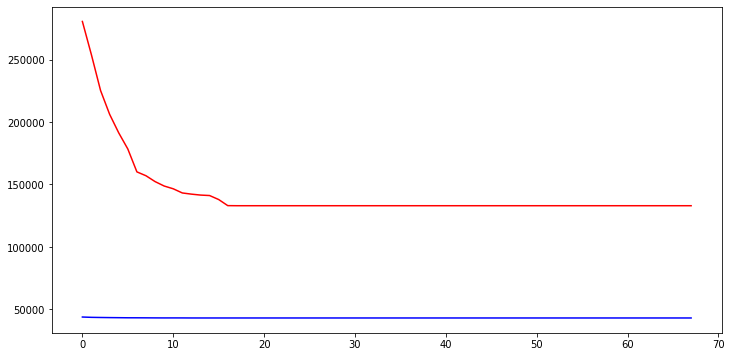

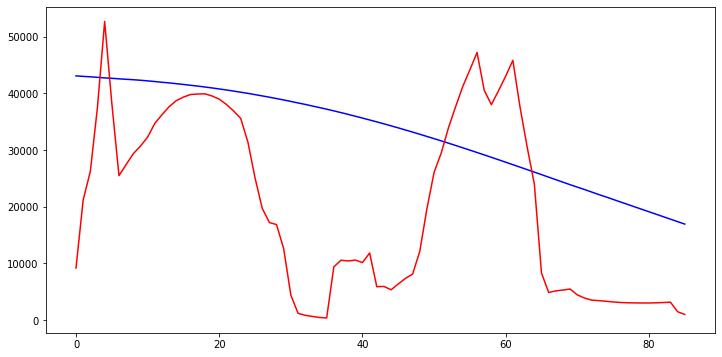

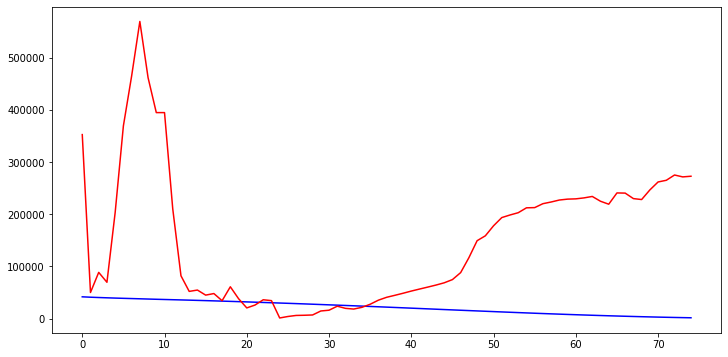

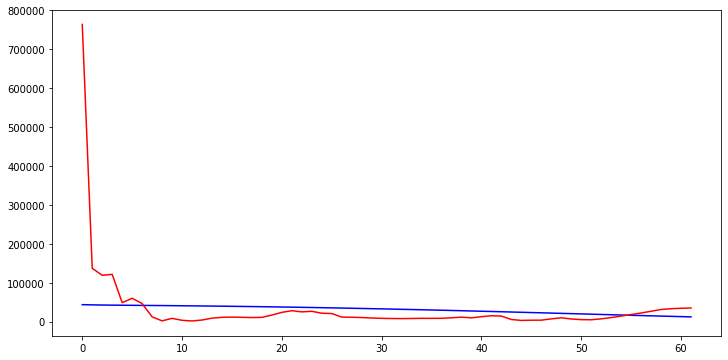

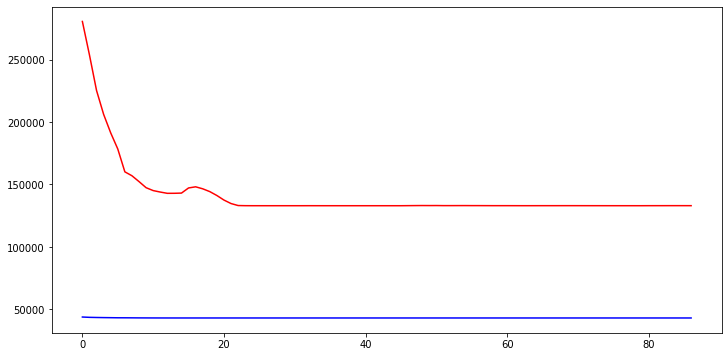

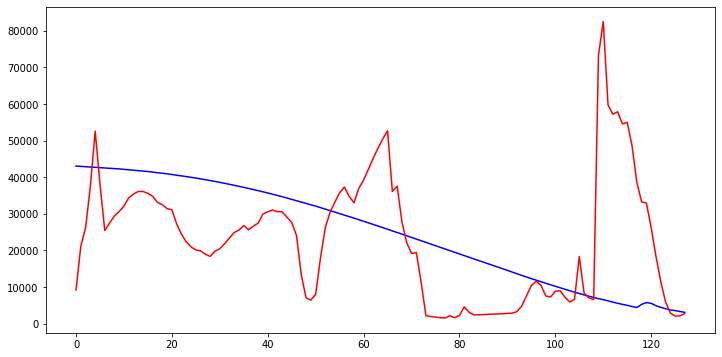

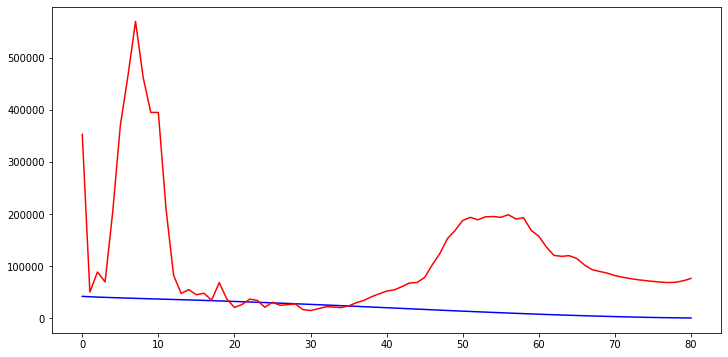

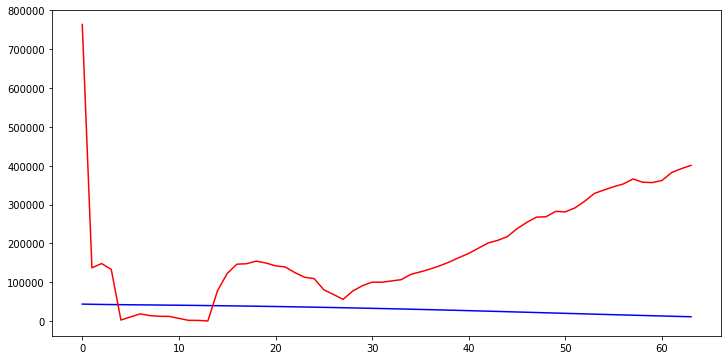

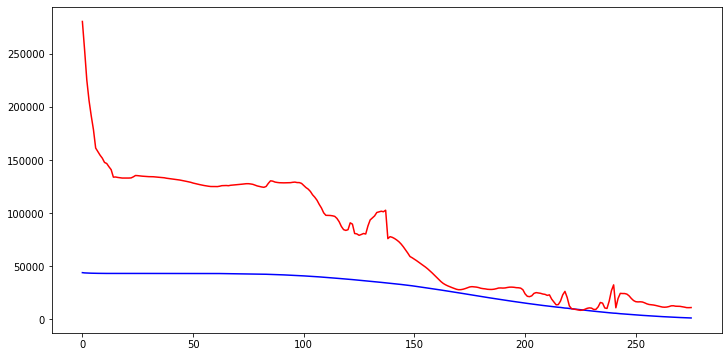

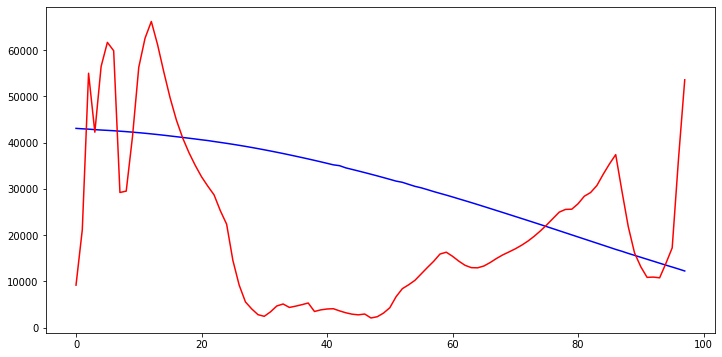

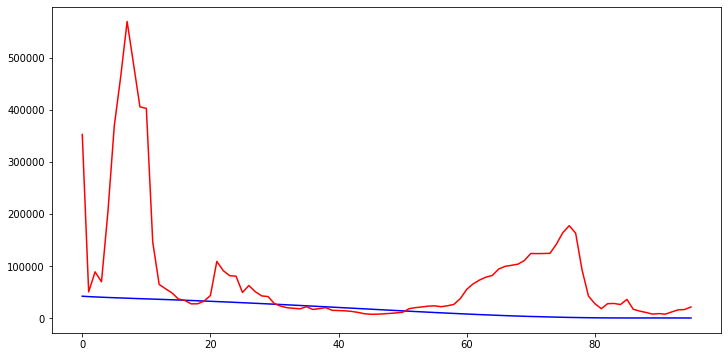

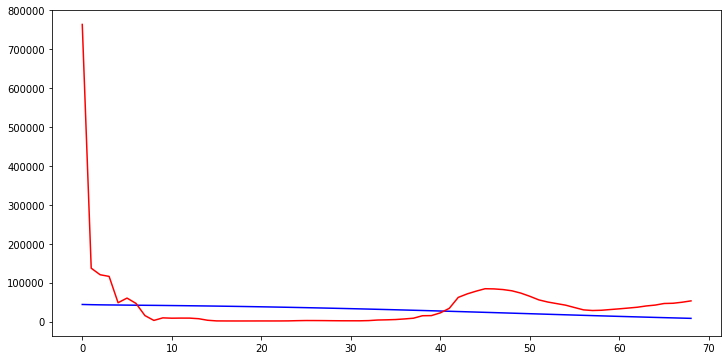

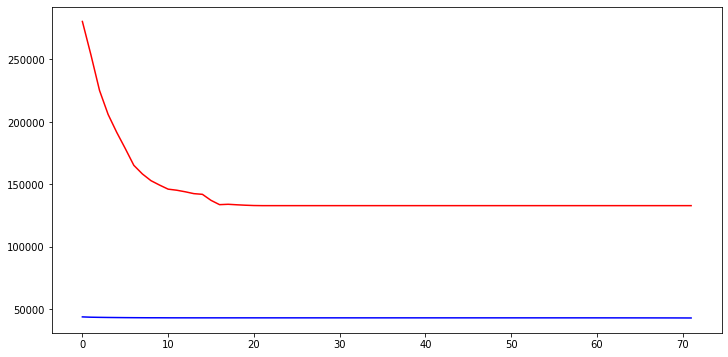

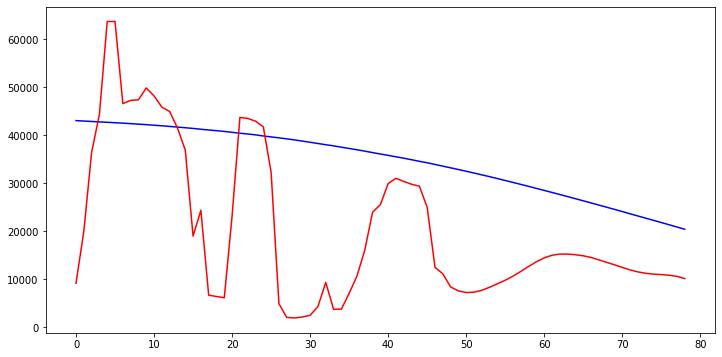

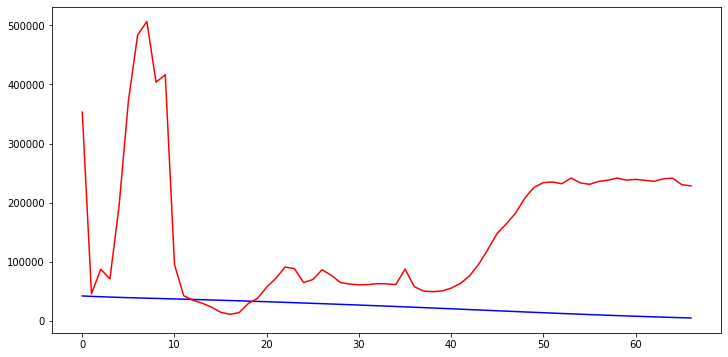

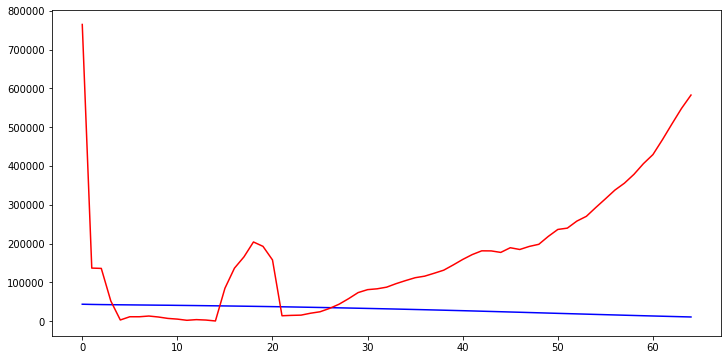

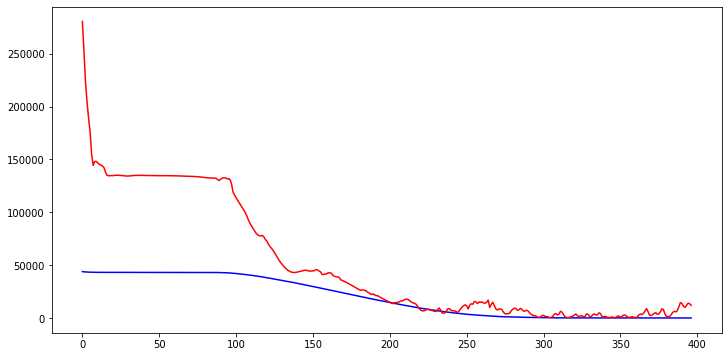

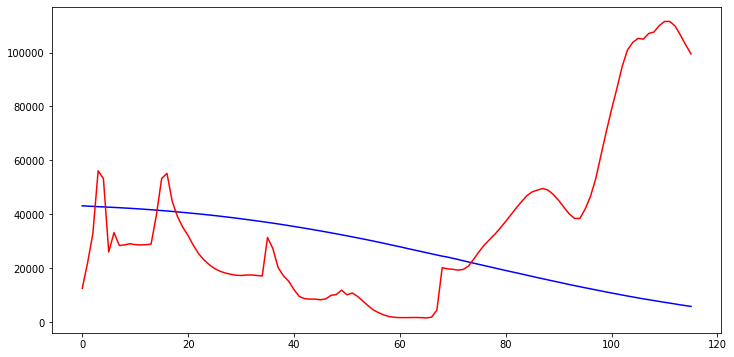

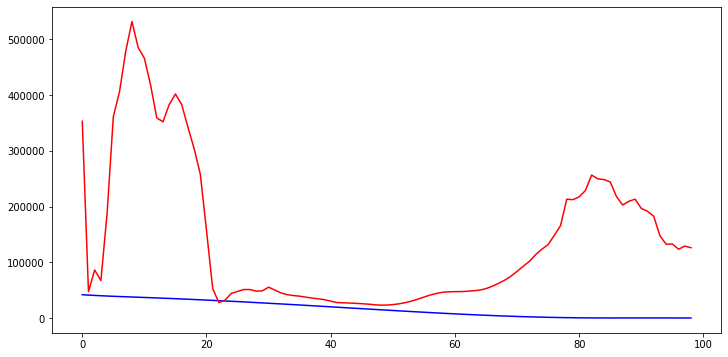

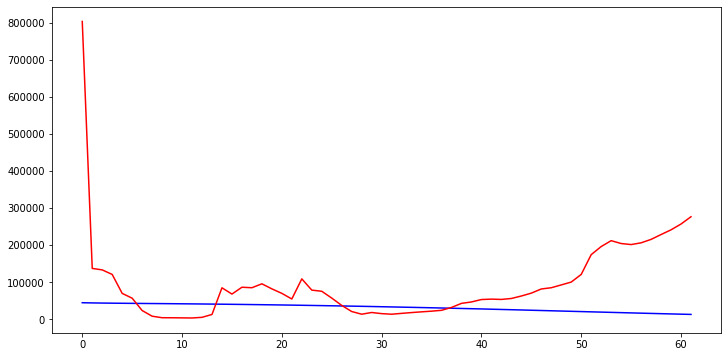

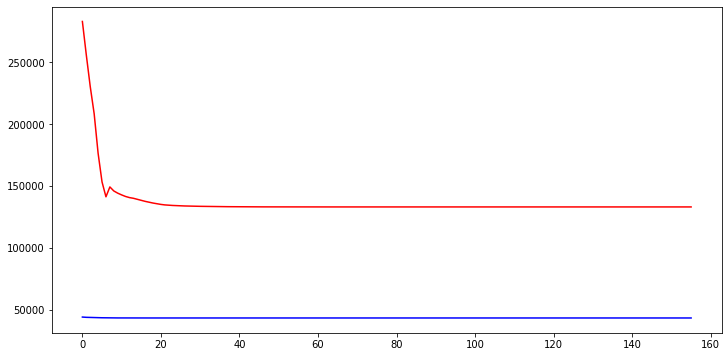

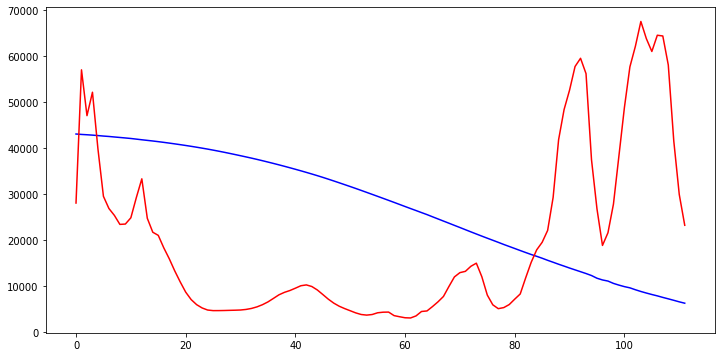

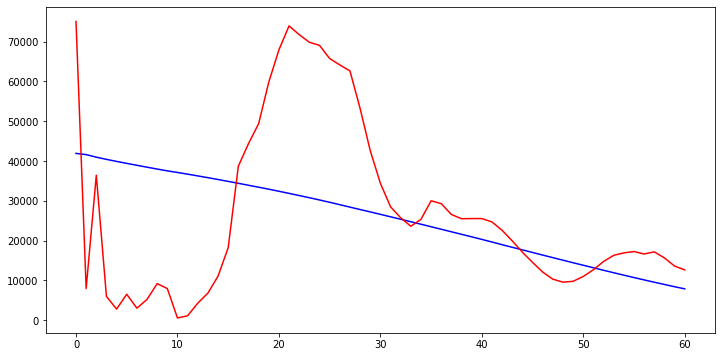

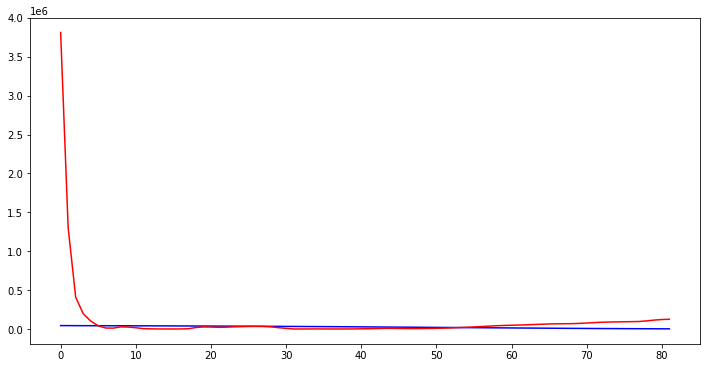

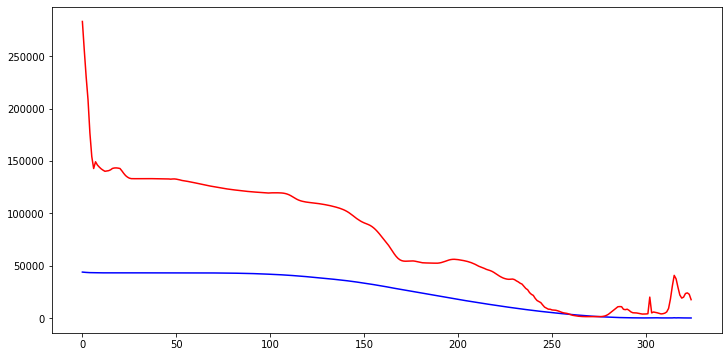

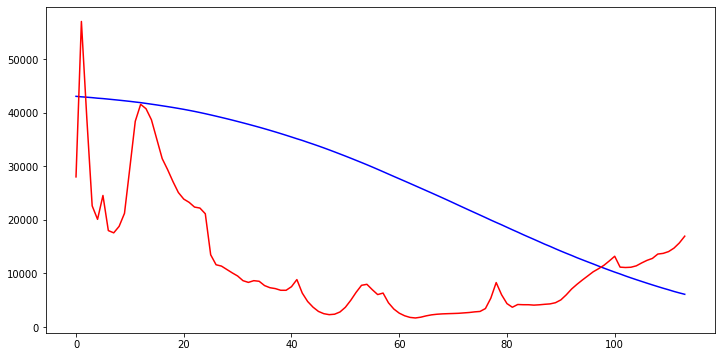

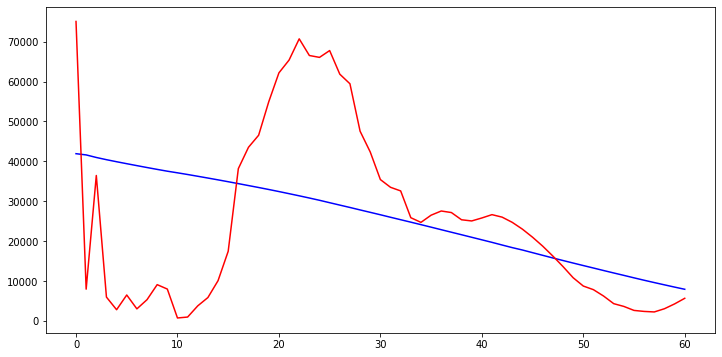

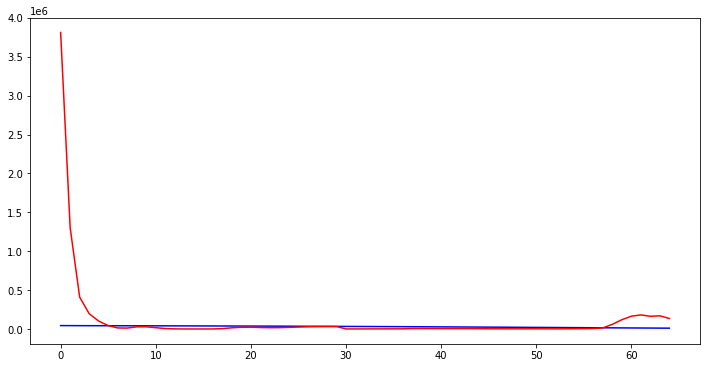

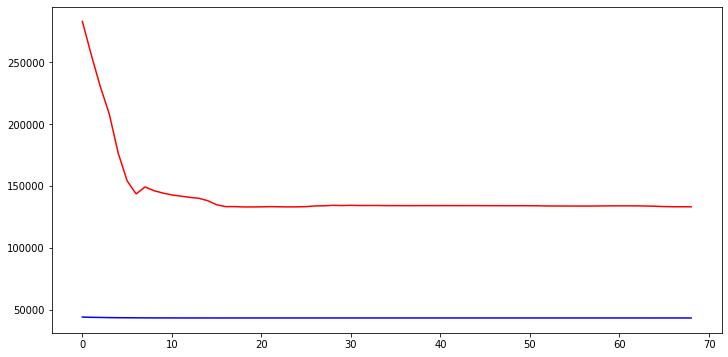

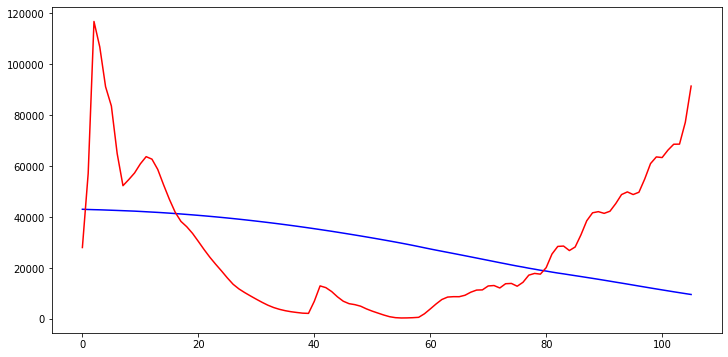

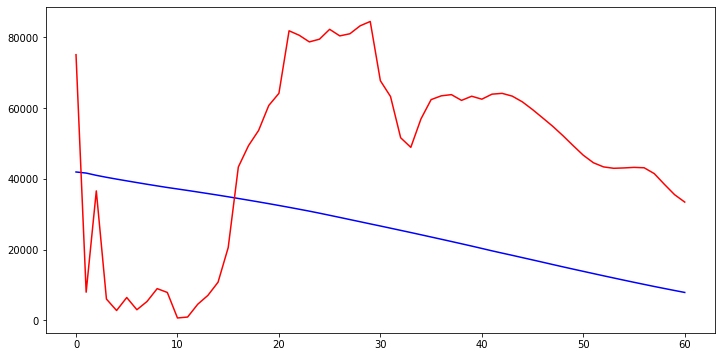

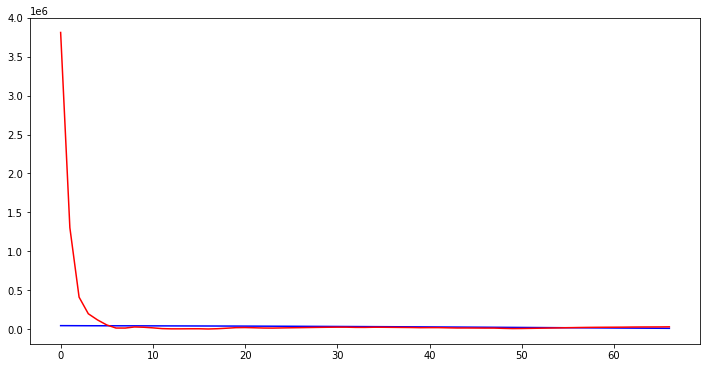

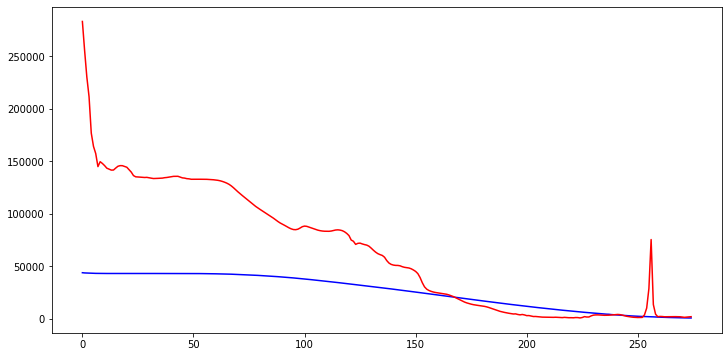

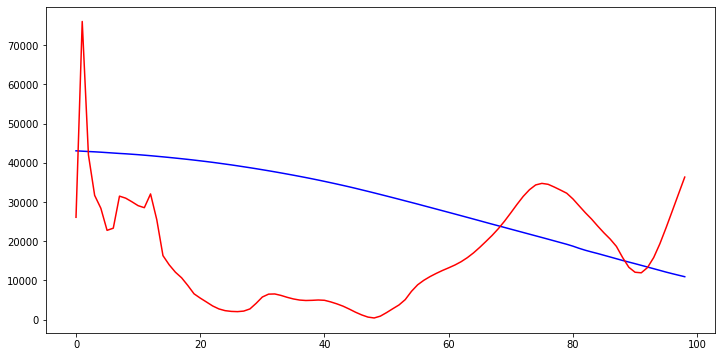

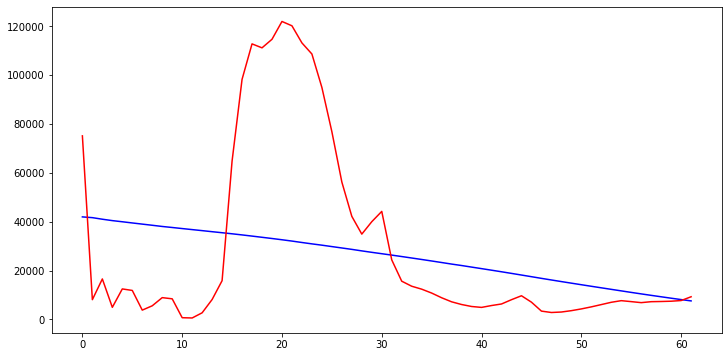

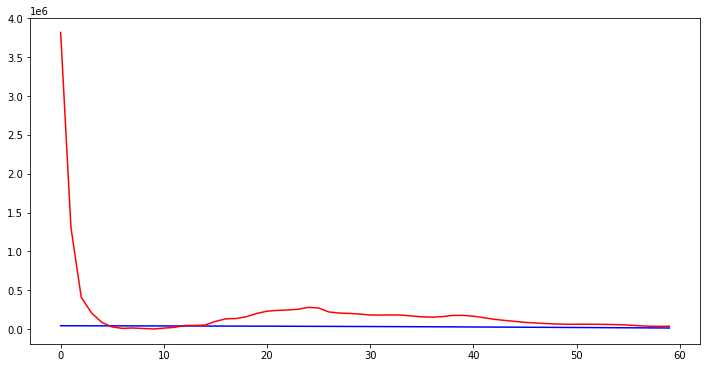

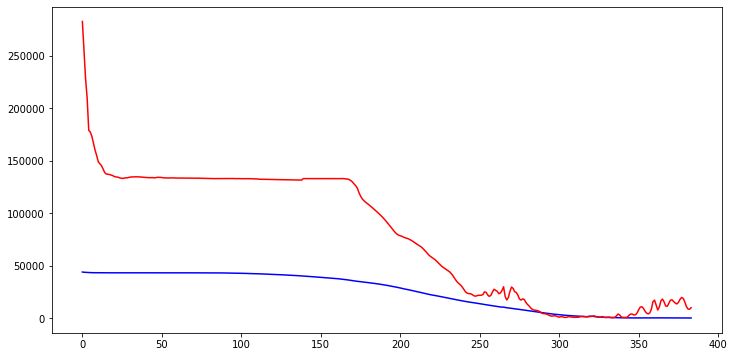

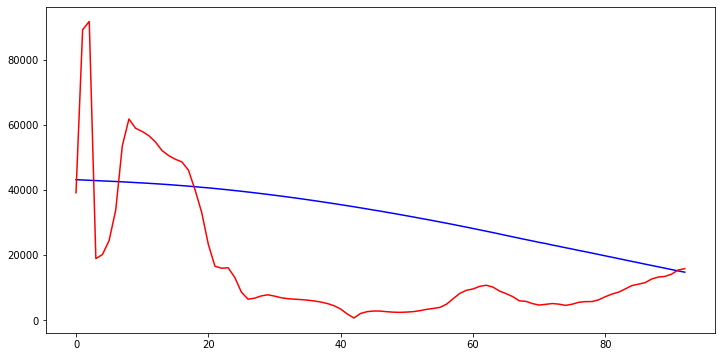

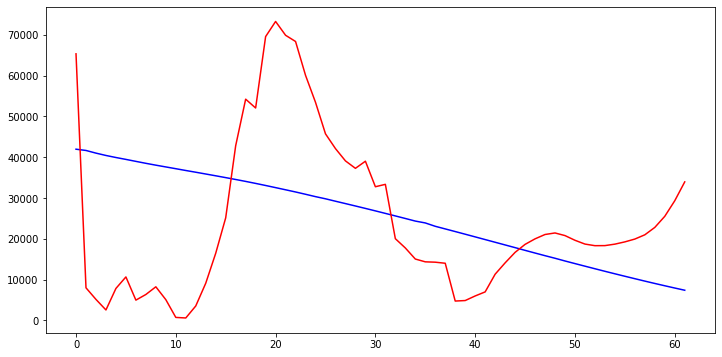

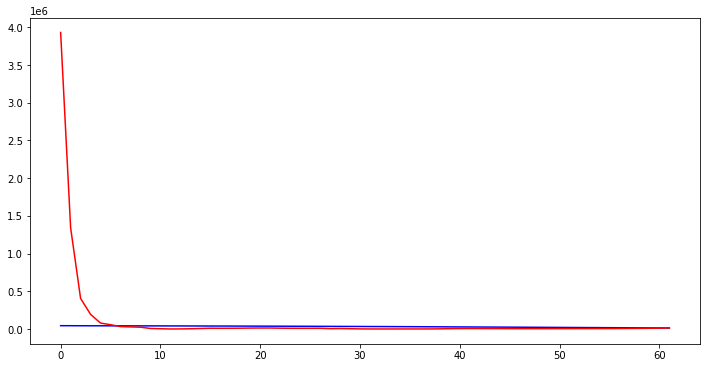

In [23]:
model_parameter_generator = get_model_parameters(n_steps_values, gamma_values, lambda_sparse_values, model_capacity_values)
has_parameters_to_consume = True
run_id = 0
while has_parameters_to_consume:
    model_parameters = next(model_parameter_generator, None)
    
    if model_parameters is None:
        has_parameters_to_consume = False
        continue
    run_id += 1
    with mlflow.start_run(run_id=None, experiment_id=experiment_id):

        print(model_parameters)
        tabnet_regressor = TabNetRegressor(**model_parameters)
        mlflow.log_params(params=model_parameters)

        # train model
        tabnet_regressor.fit(
            X_train=X_train, y_train=y_train,
            X_valid=X_val, y_valid=y_val,
            max_epochs=max_epochs,
            patience=50,
            batch_size=1024, 
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False
        )

        plot_learning_curves(losses_train=tabnet_regressor.losses_train, losses_valid=tabnet_regressor.losses_valid, plot=False, save=True)

        # log results
        mlflow.log_metric('mse_valid', tabnet_regressor.best_cost)
        mlflow.log_artifacts('./artifacts/')

        delete_artifacts()
    